# **Capstone Project Proposal: Predicting Housing Prices with Machine Learning**


## Background
I'm excited to delve into the realm of machine learning with my first project using AWS SageMaker. My aim is to explore data analysis and model training on the SageMaker platform by tackling the challenge of predicting housing prices.

## Contents

1. [Background](#Background)
2. [Approach](#Approach)
3. [Environment](#Environment)
4. [Data](#Data)
5. [SageMaker](#SageMaker)
6. [Hyperparameters](#Hyperparameters)
7. [Conclusions](#Conclusions)

## Approach

For this project, I'm not aiming for a top-ranking solution in the "House Prices" Kaggle competition. Instead, I'm focusing on leveraging SageMaker's infrastructure to develop a model that outperforms a naive solution. Given the wealth of information available on the Kaggle competition page, I'll skip extensive data exploration and feature engineering.

My plan is to use a default algorithm provided by SageMaker, with eXtreme Gradient Boosting (XGBoost) being a promising choice for regression problems like this. To kickstart the process, I'll utilize a SageMaker example notebook on XGBoost, allowing me to bypass syntax hunting and focus on the workflow.

## Environment

### AWS Setup
1. Begin by setting up an AWS account on aws.amazon.com.
2. Access the SageMaker service and create a new notebook instance.
3. Opt for a cost-effective instance type like "ml.t2.medium" to keep expenses minimal.
4. Utilize the default IAM role for simplicity.
5. Start the notebook instance and open a terminal for future use.

## Data

I'll be using the dataset provided by the "House Prices" Kaggle competition. This dataset contains various features such as square footage, number of bedrooms, and location details, which will be used to predict housing prices.

## SageMaker

I'll employ AWS SageMaker for data preprocessing, model training, and evaluation. This cloud-based platform offers a streamlined workflow for building and deploying machine learning models at scale.

## Hyperparameters

Given the simplicity of this project, I'll primarily rely on default hyperparameters provided by the chosen algorithm. However, I'll explore tuning them if time permits to enhance model performance.

## Conclusions

In this project, I aim to gain hands-on experience with AWS SageMaker and machine learning workflows. While the focus is not on achieving top-tier performance in the Kaggle competition, I expect to develop a functional model that demonstrates proficiency in utilizing SageMaker's capabilities. Moving forward, I plan to explore more advanced techniques and delve deeper into feature engineering for improved predictions.

### Enabling Kaggle Tools
For convenience, let's enable the Kaggle API and command line tools. First, we install the Python package to get the command line tools.

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions list

__Kaggle API__

Then we enable the Kaggle API. This assumes you have an account on Kaggle. It's free and only takes a minute. Once you have that, follow instructions here to retrieve your kaggle.json file

https://github.com/Kaggle/kaggle-api

Using the AWS Jupyter files tab, upload your kaggle.json. I had to use the Jupyter terminal to move it to ~/.kaggle/

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ../.kaggle/

Finally, we follow the advice to make sure our Kaggle key isn't readable by other users of this system. This is a corner we could have cut on this private EC2 instance.

In [ ]:
!chmod 600 ../.kaggle/kaggle.json

**Choosing the labels**

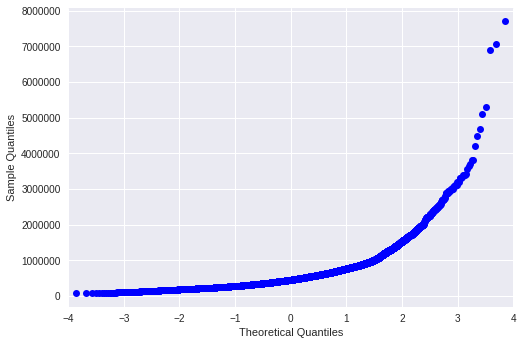

In [29]:
import statsmodels.api as sm
fig=sm.qqplot(train['price'])
plt.show()

The QQ Plot reveals a non-normalized distribution of the label. Let's try logrithm transform. 

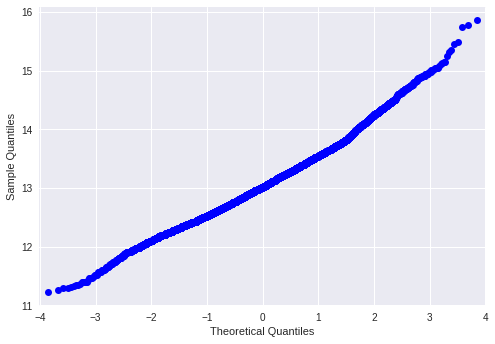

In [30]:
fig=sm.qqplot(np.log(train['price']))
plt.show()

### Python and SageMaker Setup

Now we start coding in Python. We import the necessary libraries and create a connection to the SageMaker service.

In [ ]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
from sagemaker.predictor import csv_serializer    # Converts strings for HTTP POST requests on inference

In [ ]:
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/house_price_xgboost'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name 
smclient = boto3.Session().client('sagemaker')



## Data

### Retrieval
Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download -p ./data house-prices-advanced-regression-techniques

### Exploration
Now lets read this into a Pandas data frame and take a look, but just a quick one. Normally, we would investigate the data. But because our goal is to get a model trained end-to-end on SageMaker as quickly as possible, we'll skip all those best practices and see what happens.

In [ ]:
df_train = pd.read_csv('./data/train.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
df_train.head()

### First submission

Before we go further investigating the data and creating sophisticated predictive models, let's make sure we're able to submit something, anything, to the competition. The idea is to validate our pipeline and that we've understood the submission format. And by getting an initial score, we're better able to judge future improvements.

The required format is provided in the "sample_submission.csv" file retrieved earlier.

In [ ]:
!head ./data/sample_submission.csv

For the purpose of test driving the submission process, we don't need a good result, just a valid one. A trivial attempt would be to use the means of the training set as the answer for all items in the testing set.

In [ ]:
df_train.describe()['SalePrice']

In [ ]:
df_competition = pd.read_csv('./data/test.csv')
df_competition.head()

In [ ]:
df_submit = pd.DataFrame(df_competition['Id'], dtype=int)
df_submit['SalePrice'] = df_train.describe()['SalePrice']['mean']
df_submit.head()
df_submit.tail()

In [ ]:
df_submit.to_csv('./data/sub_mean.csv',index=False)
!head ./data/sub_mean.csv
!tail ./data/sub_mean.csv


That is the format we were looking for. Now let's try to submit it through the Kaggle API:

> usage: kaggle competitions submit [-h] -f FILE_NAME -m MESSAGE [-q] [competition]

In [ ]:
!kaggle competitions submit -f ./data/sub_mean.csv -m "Means-based submission" house-prices-advanced-regression-techniques
#
# Need UI buffer space so horizontal scrollbar does not get in the way

On Kaggle.com under "My submission", I can see that this trivial technique gives a public score of 0.42949. At the time of this writing, this technique places us 4515 out of 4745 on the public leaderboard. Clearly not a good score, but we didn't expect it to be.

Now that our submission pipeline has been validated, we can turn our attention to submitting something more clever through SageMaker.

### Data Transformation

To create a more sophisticated solution, we should know our data. The pros urge us to do the following:

> Cleaning up data is part of nearly every machine learning project.  It arguably presents the biggest risk if done incorrectly and is one of the more subjective aspects in the process.  Several common techniques include:

>* Handling missing values: Some machine learning algorithms are capable of handling missing values, but most would rather not.  Options include:
 * Removing observations with missing values: This works well if only a very small fraction of observations have incomplete information.
 * Removing features with missing values: This works well if there are a small number of features which have a large number of missing values.
 * Imputing missing values: Entire [books](https://www.amazon.com/Flexible-Imputation-Missing-Interdisciplinary-Statistics/dp/1439868247) have been written on this topic, but common choices are replacing the missing value with the mode or mean of that column's non-missing values.
* Converting categorical to numeric: The most common method is one hot encoding, which for each feature maps every distinct value of that column to its own feature which takes a value of 1 when the categorical feature is equal to that value, and 0 otherwise.
* Oddly distributed data: Although for non-linear models like Gradient Boosted Trees, this has very limited implications, parametric models like regression can produce wildly inaccurate estimates when fed highly skewed data.  In some cases, simply taking the natural log of the features is sufficient to produce more normally distributed data.  In others, bucketing values into discrete ranges is helpful.  These buckets can then be treated as categorical variables and included in the model when one hot encoded.
* Handling more complicated data types: Mainpulating images, text, or data at varying grains is left for other notebook templates.

> Luckily, some of these aspects have already been handled for us, and the algorithm we are showcasing tends to do well at handling sparse or oddly distributed data.  Therefore, let's keep pre-processing simple.

So, for the purpose of racing to the end, we'll disregard most of it and simply convert categorical variables to numerical data

In [ ]:
df_train = pd.get_dummies(df_train)   # Convert categorical variables to sets of indicators
df_train.describe()

### Feature engineering

If we cared about the score, we would totally look into that.

We, however, will heed this advice regarding creating a validation test from our test data:

> When building a model whose primary goal is to predict a target value on new data, it is important to understand overfitting.  Supervised learning models are designed to minimize error between their predictions of the target value and actuals, in the data they are given.  This last part is key, as frequently in their quest for greater accuracy, machine learning models bias themselves toward picking up on minor idiosyncrasies within the data they are shown.  These idiosyncrasies then don't repeat themselves in subsequent data, meaning those predictions can actually be made less accurate, at the expense of more accurate predictions in the training phase.

> The most common way of preventing this is to build models with the concept that a model shouldn't only be judged on its fit to the data it was trained on, but also on "new" data.  There are several different ways of operationalizing this, holdout validation, cross-validation, leave-one-out validation, etc.  For our purposes, we'll simply randomly split the data into 3 uneven groups.  The model will be trained on 70% of data, it will then be evaluated on 20% of data to give us an estimate of the accuracy we hope to have on "new" data, and 10% will be held back as a final testing dataset which will be used later on.

In [ ]:
#model_data = data
train_data, validation_data, test_data = np.split(df_train.sample(frac=1, random_state=1729), [int(0.7 * len(df_train)), int(0.9*len(df_train))])  

In [ ]:
train_data.shape

>Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format.  For this example, we'll stick to CSV.  Note that the first column must be the target variable and the CSV should not include headers.  Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before.  This avoids any misalignment issues due to random reordering.

In [ ]:
#pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
#pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([train_data['SalePrice'], train_data.drop(['SalePrice'], axis=1)], axis=1).to_csv('./data/sm_train.csv', index=False, header=False)
pd.concat([validation_data['SalePrice'], validation_data.drop(['SalePrice'], axis=1)], axis=1).to_csv('./data/sm_validation.csv', index=False, header=False)
!ls -l ./data

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('./data/sm_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('./data/sm_validation.csv')


## SageMaker Training with XGBoost

* Introduction to XGBoost

We've chosen XGBoost for our SageMaker training because it's tailor-made for the job. 
Our dataset presents skewed distributions, correlated features, and non-linear relationships 
with the target variable. Additionally, we prioritize predictive accuracy over interpretability 
for future prospect targeting, making gradient boosted trees an ideal choice.


* Overview of Gradient Boosted Trees


At a fundamental level, gradient boosted trees excel by amalgamating predictions from 
numerous simple models, each refining the weaknesses of its predecessors. This collaborative 
approach often outshines the performance of complex models. 
Further insights into gradient boosting and its distinctions from similar algorithms are 
available in other Amazon SageMaker resources.


* The Power of XGBoost


XGBoost, a leading open-source package for gradient boosted trees, stands out for its 
computational prowess, rich feature set, and impressive track record in machine learning 
competitions. Let's kickstart our journey with a straightforward XGBoost model, leveraging 
Amazon SageMaker's managed, distributed training infrastructure.


* Specifying the ECR Container Location

container = get_image_uri(boto3.Session().region_name, 'xgboost')

* Uploading Data to S3

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

* Configuring SageMaker Estimator 

xgb_estimator = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

* Setting Hyperparameters for XGBoost

xgb_estimator.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100)

* Training the XGBoost Model

xgb_estimator.fit({'train': s3_input_train, 'validation': s3_input_validation})


In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

> Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3, which also specify that the content type is CSV.

In [ ]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

> Let's begin by delineating the training parameters for the estimator. These encompass:

1. Selecting the `xgboost` algorithm container.
2. Designating the IAM role.
3. Specifying the type and quantity of training instances.
4. Establishing the S3 destination for output data.
5. Setting the algorithm hyperparameters.

Following that, we'll employ the `.fit()` function, detailing:

1. The S3 location for output data, considering both the training and validation sets.

Take note: We are initiating an m4.xlarge instance, currently priced at 22.2 cents per hour. It will remain active throughout the entirety of our model training.

In [ ]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

# These are the default parameters that came with the Targeting Direct Marketing example
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

__A Few Notable Observations__

The instance launch typically consumes approximately 2 minutes before it initiates. This period might feel lengthy, leaving one staring at the screen. However, once operational, the algorithm's training process merely requires 39 seconds, coinciding with the duration we are billed. Remarkably efficient, wouldn't you say? Consider the analogy: borrowing someone else's computer for just 39 seconds.

Yet, intriguingly, a process spanning 39 seconds translates into nearly 3 minutes of wall clock time.

### Model Deployment

Having successfully trained the `xgboost` algorithm on our dataset, the next step is to deploy a model accessible via a real-time endpoint.

This marks the initiation of our third instance. To clarify, the first instance serves as the environment for running this notebook, while the second instance handles the model training. Now, this third instance is dedicated to conducting inferences.

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

__Observations__
Again, starting a new instance takes several minutes.

### Initial Evaluation of the SageMaker Model

Before proceeding, let's assess the performance of our SageMaker (SM) model in predicting the SalePrice values we already possess.

To facilitate data transmission to and from our endpoint, we need to establish a method. Presently, our data exists as NumPy arrays within the memory of our notebook instance. To transmit it via an HTTP POST request, we'll serialize it into a CSV string and subsequently decode the resultant CSV.

*Note: It's imperative to bear in mind that for inference using the CSV format, SageMaker XGBoost mandates that the data excludes the target variable.*

In [ ]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Like we did for our training data, we need to convert the categorical columns in the "test" data provided by Kaggle to numerical format.

In [ ]:
df_competition = pd.get_dummies(df_competition)
df_competition.shape

In [ ]:
df_train.shape

__Note__: Our competition test data differs from our training data by 18 columns. One column's absence is expected, as 'SalePrice' is not included in the Kaggle test data. The remaining disparities stem from variations in values across different columns, especially after categorical data transformation into numerical data via `get_dummies()`.

Given that Random Forest, which includes XGBoost algorithms, necessitates a fixed number of columns, I've opted to pad our competition data with the requisite additional columns. I must admit uncertainty regarding the impact of these surplus columns on the XGBoost algorithm. My strategy assumes their negligible influence due to their lack of distribution in the data.

A more optimal approach would involve reading and processing all data, both training and competition sets, simultaneously.

In [ ]:
df_comp_padded=df_competition
for x in range(0, 18):
    df_comp_padded[x] = pd.Series(1, index=df_comp_padded.index)
df_comp_padded.shape

In [ ]:
df_comp_padded.head()

In [ ]:
def predict(data):
    ids = data['Id']
    saleprice = np.array(xgb_predictor.predict(data.as_matrix()).decode('utf-8').split(',')).astype(np.float)
    predictions = list(zip(ids,saleprice))
    return predictions

#predictions = predict(test_data.drop(['SalePrice'], axis=1).as_matrix())
#predictions = predict(kaggle_data.drop(['SalePrice'], axis=1).as_matrix())
#predictions = predict(kd.as_matrix())
%time predictions = predict(df_comp_padded)

__Observations__
Asking the model to predict the saleprice of 1459 houses took about one half second. That feels pretty quick for real-time human interaction.

Let's take a quick look at the predictions:

In [ ]:
predictions[0:5]

These results deviate from our earlier trivial submission based on means. Let's proceed with submitting them and evaluating the performance of the default XGBoost algorithm.

### First SM submission

In [ ]:
np.array(predictions).shape

In terms of shape, it's consistent with the submission requirements, minus the colum headers.

In [ ]:
#np.savetxt("../data/housing.csv", predictions, delimiter=",", header='Id,SalePrice', fmt='%u')

In [ ]:
df = pd.DataFrame(predictions, columns=['Id', 'SalePrice'])
print(df.head())

In [ ]:
df.to_csv('./data/sub_xgboost_default.csv', header=True, index=False)

In [ ]:
!kaggle competitions submit -f ./data/sub_xgboost_default.csv -m "Default XGBoost submission" house-prices-advanced-regression-techniques
#
# Damned scroll bar

This default XGBoost submittion gives me a public score of 0.17203, which is good for 3640th place as of this writing, a significant improvement on our means-based result! We thus have good confidence we've improved our modeling.

## Hyperparameters 

### Configuration

Now, let's leverage one of SageMaker's strengths: automated hyperparameter tuning!

>*Please note, the default settings below indicate that the hyperparameter tuning job might take around 30 minutes to complete.*

With our dataset prepared, we're poised to train models. Before diving in, it's crucial to acknowledge the presence of algorithm settings called "hyperparameters." These parameters can significantly influence the performance of trained models. For instance, the XGBoost algorithm encompasses numerous hyperparameters, and selecting the right values for these is paramount to achieving desired training results. However, identifying the optimal hyperparameter setting is complex and often requires systematic exploration.

This is where SageMaker's hyperparameter tuning comes into play. We'll automate this exploration process effectively. Specifically, we'll define a range or list of potential values for each hyperparameter we intend to tune. SageMaker hyperparameter tuning will then orchestrate multiple training jobs with varied hyperparameter settings. It evaluates these jobs based on a predefined "objective metric" and adapts subsequent attempts based on previous results. Each hyperparameter tuning job operates within a set budget, completing after a specified number of training jobs.

Let's configure the hyperparameter tuning job by defining a JSON object that specifies the following information:
- The ranges of hyperparameters we aim to tune
- The total number of training jobs and the level of parallelism (i.e., how many jobs run simultaneously). While higher parallelism speeds up tuning, it might compromise accuracy. For this example, we'll set a higher parallelism value to keep it concise.
- The objective metric used for evaluating training results. In this example, we'll select *validation:auc* to maximize its value throughout the tuning process. Note: the chosen objective metric must be emitted by the algorithm during training.

In this instance, we'll tune four hyperparameters:
- *eta*: Step size shrinkage used in updates to prevent overfitting.
- *alpha*: L1 regularization term on weights.
- *min_child_weight*: Minimum sum of instance weight needed in a child.
- *max_depth*: Maximum depth of a tree.

It's essential to recognize that I'm uncertain whether these are the correct parameters to tune, or if their ranges are appropriate. At this stage, our primary focus is on ensuring the end-to-end process functions smoothly. We have our baseline result to safeguard against any deterioration.

In [ ]:
from time import gmtime, strftime, sleep
tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())

print (tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha",            
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth",
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:rmse",
      "Type": "Minimize"
    }
  }

Next, we'll configure the training jobs that the hyperparameter tuning job will initiate. This involves defining a JSON object specifying the following details:

- The container image for the algorithm (XGBoost).
- Input configuration for the training and validation data.
- Configuration for the output of the algorithm.
- The values of any algorithm hyperparameters not tuned in the tuning job (StaticHyperparameters).
- The type and quantity of instances for the training jobs.
- The stopping condition for the training jobs.

Again, as we're utilizing the built-in XGBoost algorithm, it emits two predefined metrics: *validation:auc* and *train:auc*. However, for our Kaggle competition, we require "reg:linear", or considering my uncertainty, something closer to "reg:linear". 

It's important to note that if you bring your own algorithm, your algorithm will emit metrics independently. In such cases, you'll need to incorporate a MetricDefinition object to define the format of those metrics using regex, enabling SageMaker to extract them accurately.

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(region, 'xgboost', repo_version='latest')
     
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)
    
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "rmse",
      "num_round": "100",
      "objective": "reg:linear",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

__Launch Hyperparameter Tuning__

To commence the hyperparameter tuning process, we'll invoke the `create_hyper_parameter_tuning_job` API. Once initiated, we can monitor the progress of the hyperparameter tuning job through the SageMaker console until its completion.

__Costs__

Considering we've specified three parallel jobs, three instances will be engaged. Consequently, we'll incur three times the cost per hour compared to our original training.

In [ ]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)

Returning to the SageMaker dashboard, we'll find our three concurrent training jobs in progress!

Before proceeding further, let's perform a quick check of the hyperparameter tuning job's status to ensure it commenced successfully.

In [ ]:
smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

### Analyzing Tuning Job Results

To delve into the outcomes of the hyperparameter tuning process, please consult "HPO_Analyze_TuningJob_Results.ipynb" for a glimpse into example code for analyzing the tuning job results.

Despite my best efforts, the tuning job returned different parameters for XGBoost. Surprisingly, implementing these adjustments yielded nearly identical results on the public leaderboard. Consequently, I've opted not to burden you with redundant code for retraining the algorithm and resubmitting to the competition.

This discrepancy could stem from various factors. It's plausible that I selected the wrong parameters for fine-tuning. Alternatively, the most substantial improvements might lie elsewhere, such as in feature engineering, outlier removal, or the inadvertent influence of spurious columns.

Nonetheless, we now possess a pipeline that facilitates further experimentation and exploration!

### Tidying Up

Once you've completed your tasks with this notebook, execute the cell below. This action will eliminate the hosted endpoint you created, ensuring there are no charges incurred from an unattended instance.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

# 2. Regression Models

In the realm of real estate, accurately predicting house prices is a pivotal task with far-reaching implications for buyers, sellers, and investors alike. At the heart of this endeavor lies regression modeling, a powerful analytical technique that seeks to uncover the intricate relationships between various factors and the final sale price of a property. Through the lens of regression, we embark on a journey to decode the multifaceted dynamics that influence housing markets, from location and square footage to amenities and market trends.

In this introductory exploration of regression modeling for house price predictions, we embark on a quest to demystify the complexities of this critical domain. By harnessing the power of data and statistical methods, we endeavor to construct models that not only capture the nuances of the housing market but also provide actionable insights for stakeholders navigating this ever-evolving landscape. Join us as we delve into the intricacies of regression analysis, unlocking its potential to illuminate the path toward informed decision-making in the realm of real estate.

In [32]:
Models = []
RMSE = []

## 2.1 Linear Regression

In [33]:
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [34]:
Models.append('Normal Linear Regression')
reg = LinearRegression(n_jobs=-1)
reg.fit(train_[columns],train_['log_price'])
pred = np.exp(reg.predict(test_))
Accuracy = sqrt(mse(pred,test['price']))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)
RMSE.append(Accuracy)

========================================RMSE: 271173.6575397252========================================


## 2.2 Linear Regression With Step 2&3 Polynomial Transformation

In [35]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
('sc',StandardScaler()),
('poly',PolynomialFeatures(include_bias=True)),
('reg',LinearRegression())
])
model = GridSearchCV(pipe,param_grid={'poly__degree':[2,3]})
model.fit(train_[columns],train_['log_price'])
degree = model.best_params_
print(degree)
pred = np.exp(model.predict(test_))
Accuracy = sqrt(mse(pred,test['price']))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)
RMSE.append(Accuracy)

{'poly__degree': 2}
========================================RMSE: 198655.91343015822========================================


In [36]:
Models.append('LinearRegression Step2 Polynominal')

## 2.3 Lasso Regression With Step 2 Polynomial Transformation

In [37]:
from sklearn.linear_model import Lasso

In [38]:
pipe = Pipeline([
('sc',StandardScaler()),
('poly',PolynomialFeatures(degree=2,include_bias=True)),
('las',Lasso())
])
model = GridSearchCV(pipe,param_grid={'las__alpha':[0.0005,0.001,0.01]})
model.fit(train_[columns],train_['log_price'])
degree = model.best_params_
print(degree)
pred = np.exp(model.predict(test_))
Accuracy = sqrt(mse(pred,test['price']))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)
RMSE.append(Accuracy)
Models.append('Lasso')

{'las__alpha': 0.001}
========================================RMSE: 191895.2204647605========================================


## 2.4 ElasticNet Regression With Step 2 Polynomial Transformation

In [39]:
from sklearn.linear_model import ElasticNet
pipe = Pipeline([
('sc',StandardScaler()),
('poly',PolynomialFeatures(degree=2,include_bias=True)),
('en',ElasticNet())
])
model = GridSearchCV(pipe,param_grid={'en__alpha':[0.005,0.01,0.05,0.1],'en__l1_ratio':[0.1,0.4,0.8]})
model.fit(train_[columns],train_['log_price'])
degree = model.best_params_
print(degree)
pred = np.exp(model.predict(test_))
Accuracy = sqrt(mse(pred,test['price']))
print('=='*20+'RMSE: '+str(Accuracy)+'=='*20)
RMSE.append(Accuracy)
Models.append('ElasticNet Regression')

{'en__alpha': 0.01, 'en__l1_ratio': 0.1}
========================================RMSE: 191772.5193638359========================================


## 2.5 Regression Model Summary

In short, we can find that, adding features by polynomial transformation can boost the performance of the model to a large extent.

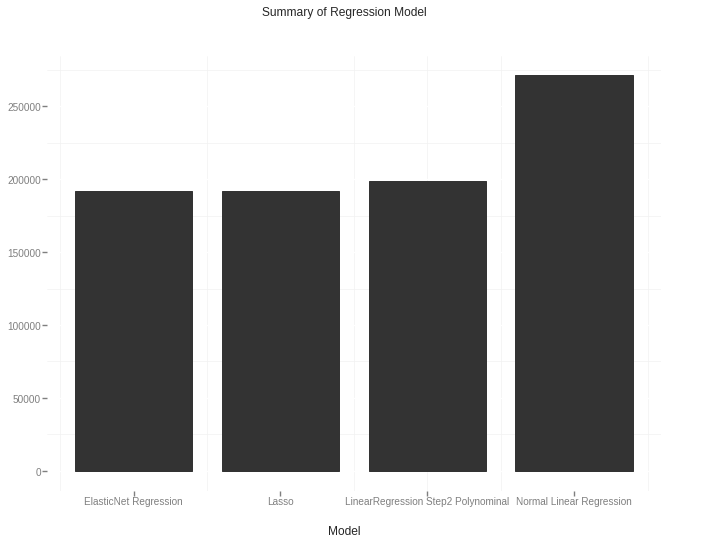

<ggplot: (-9223363289583177212)>


In [40]:
RegSummary = pd.DataFrame({'Model':Models,'RMSE':RMSE})
summary = ggplot(RegSummary,aes(x='Model',weight='RMSE'))+geom_bar()+theme_bw()+ggtitle('Summary of Regression Model')
print(summary)


## Final Thoughts

Reflecting on my experience with SageMaker, I find it to be largely positive. The platform's intuitive interface coupled with a wealth of pre-built examples makes it accessible and adaptable to various use cases. Despite utilizing automated hyperparameter tuning, I'm cognizant that I've only scratched the surface of SageMaker's potential.

However, a notable drawback I encountered revolves around the time required for instances to initialize. This delay, particularly during casual data exploration, often disrupted my workflow and impeded real-time interaction. While enhancing my proficiency in instance management could alleviate this issue, exploring alternatives such as Crestle or Papermaker might offer smoother data exploration and experimentation experiences.

To sum up, SageMaker proves to be an excellent tool for "real" research and development or production scenarios, where its robust features are indispensable. However, for casual data exploration and machine learning studies, turn-key solutions may provide a more efficient experience.

After thoroughly exploring various regression models and finding them to be somewhat satisfactory but falling short of our expectations, the logical next stride is to incorporate L2 Regularization into the mix. By integrating this as part of our feature selection process and embedding it within our pipeline alongside tree models, we aim to craft an innovative approach that could potentially yield a cutting-edge model. This fusion of techniques could unlock a new level of predictive accuracy and robustness, pushing the boundaries of what's achievable in our model development endeavors.